In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import math 
import os

In [ ]:
num_of_regions = 7

In [ ]:
clean_path = f'data.nosync/clean/ADHD200_{}'
file_list = os.listdir(clean_path)
file_list.remove('.DS_Store')

In [3]:
means_pr_roi = []
var_pr_roi = []


for subject in tqdm(file_list): #For each subject
    subject_means = {}
    subject_variance = {}

    subject_means['subject'] = subject
    subject_variance['subject'] = subject
   
    subject = np.load(f'data/clean/NYU/{subject}')
    for i in subject.files: #For each ROI 
        if i != "allow_pickle": #TODO fix, there is a strange "Allow pickle thing here sometimes??"
            roi = subject[i]
            values = []
            #Get all values from each timestep
            for t in range(roi.shape[0]):
                values += roi[t].tolist() #appends
            #Calculate mean and variance           
            subject_means[i] = sum(values)/len(values)
            subject_variance[i] = np.var(values)
    #Append to list
    means_pr_roi.append(subject_means)
    var_pr_roi.append(subject_variance)

100%|██████████| 395/395 [02:15<00:00,  2.92it/s]


In [4]:
#save stats
means_pr_roi = pd.DataFrame(means_pr_roi)
means_pr_roi.to_csv('data/stats/mean_subject.csv', sep= ";")

var_pr_roi = pd.DataFrame(var_pr_roi)
var_pr_roi.to_csv('data/stats/variance_subject.csv', sep= ";")


In [5]:
var_pr_roi['ROI_1'][var_pr_roi['ROI_1']>2].describe()

count     3.000000
mean     20.537873
std      31.272077
min       2.018199
25%       2.484942
50%       2.951686
75%      29.797710
max      56.643735
Name: ROI_1, dtype: float64

In [6]:
var_pr_roi[var_pr_roi['ROI_1']>2] # TODO visually inspect these scans, maybe there are artifacts causing interfereance ?

,subject,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
130,sfnwmrda0010077_session_1_rest_2.npz,2.018199,1.320290,1.830056,1.184891,1.797533,1.819504,1.760971
192,sfnwmrda0010111_session_1_rest_1.npz,2.951686,2.051688,2.591874,2.321350,13.845806,8.580765,7.663774
227,sfnwmrda1023964_session_1_rest_2.npz,56.643735,33.571468,34.131812,33.502569,27.563038,25.537749,35.815922


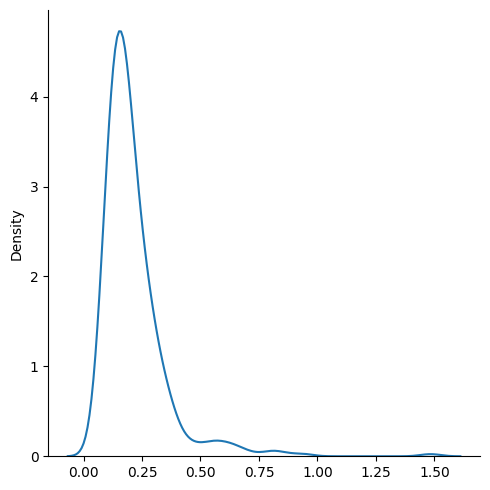

In [7]:
sns.displot(var_pr_roi['ROI_1'][var_pr_roi['ROI_1']<2].to_list(), kind= 'kde')

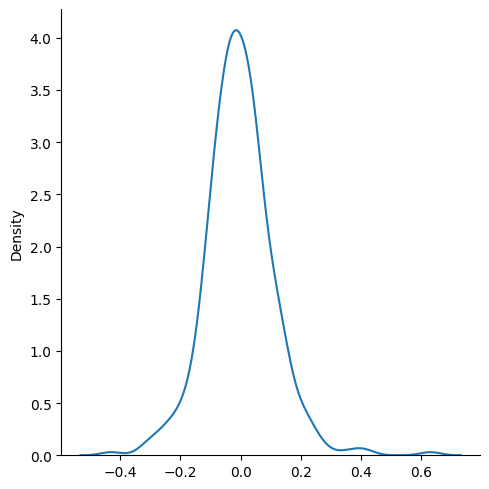

In [8]:
sns.displot(means_pr_roi['ROI_1'][var_pr_roi['ROI_1']<2].to_list(), kind= 'kde')

In [9]:
var_pr_roi

,subject,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
0,sfnwmrda0010001_session_1_rest_1.npz,0.225694,0.124442,0.133374,0.151671,0.170098,0.151474,0.176486
1,sfnwmrda0010001_session_1_rest_2.npz,0.177482,0.128813,0.147936,0.125888,0.128161,0.166097,0.178293
2,sfnwmrda0010002_session_1_rest_1.npz,0.160439,0.092114,0.132557,0.114741,0.143006,0.193157,0.187363
3,sfnwmrda0010002_session_1_rest_2.npz,0.138686,0.134019,0.153007,0.170301,0.115012,0.150752,0.192320
4,sfnwmrda0010003_session_1_rest_1.npz,0.858606,0.451212,0.588501,0.467144,0.618747,0.639020,0.641633
...,...,...,...,...,...,...,...,...
390,sfnwmrda9578663_session_1_rest_2.npz,0.187915,0.158972,0.186840,0.165289,0.442595,0.246966,0.237019
391,sfnwmrda9750701_session_1_rest_1.npz,0.215691,0.167513,0.259726,0.236395,0.137274,0.237627,0.204639
392,sfnwmrda9750701_session_1_rest_2.npz,0.211344,0.132650,0.303997,0.189052,0.139678,0.240496,0.227931
393,sfnwmrda9907452_session_1_rest_1.npz,0.098747,0.139163,0.140433,0.171957,0.139703,0.173075,0.203946


<Axes: >

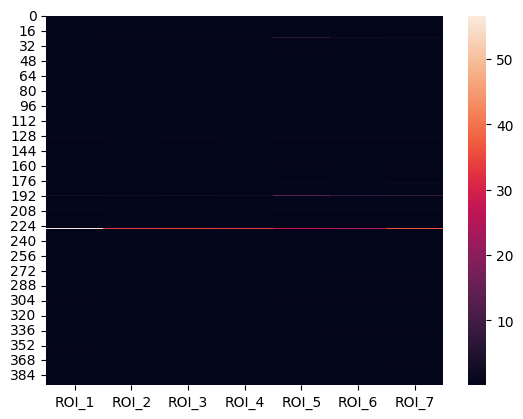

In [10]:
sns.heatmap(var_pr_roi.loc[:, var_pr_roi.columns != "subject"]) # outlier brain is LIT UP!!

<Axes: >

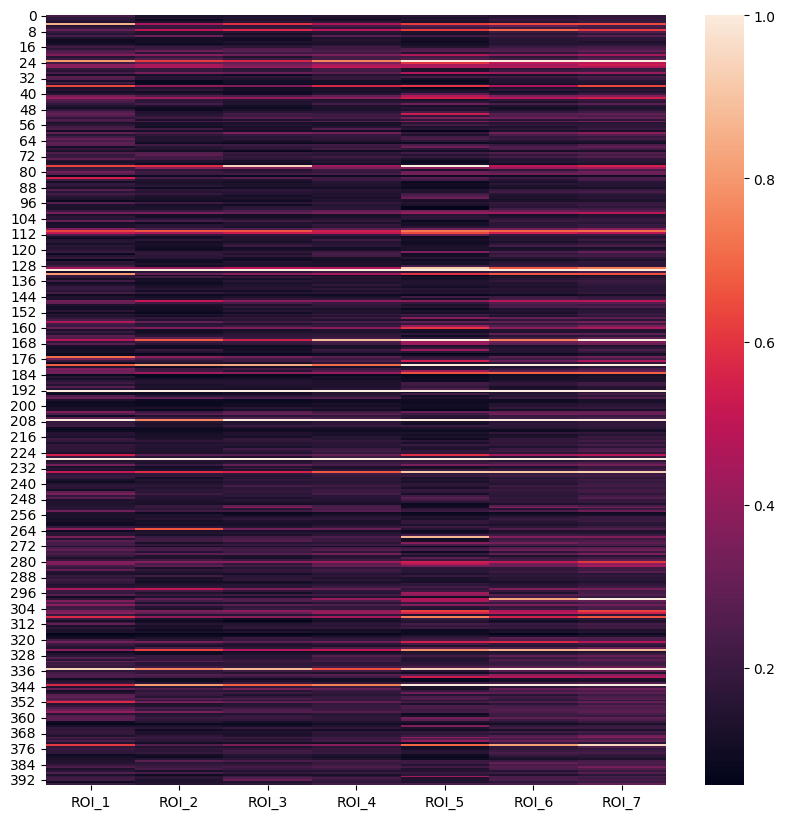

In [11]:
plt.figure(figsize=(10, 10))

sns.heatmap(var_pr_roi.loc[:, var_pr_roi.columns != "subject"], vmax = 1) # if we ignore huge values

<Axes: >

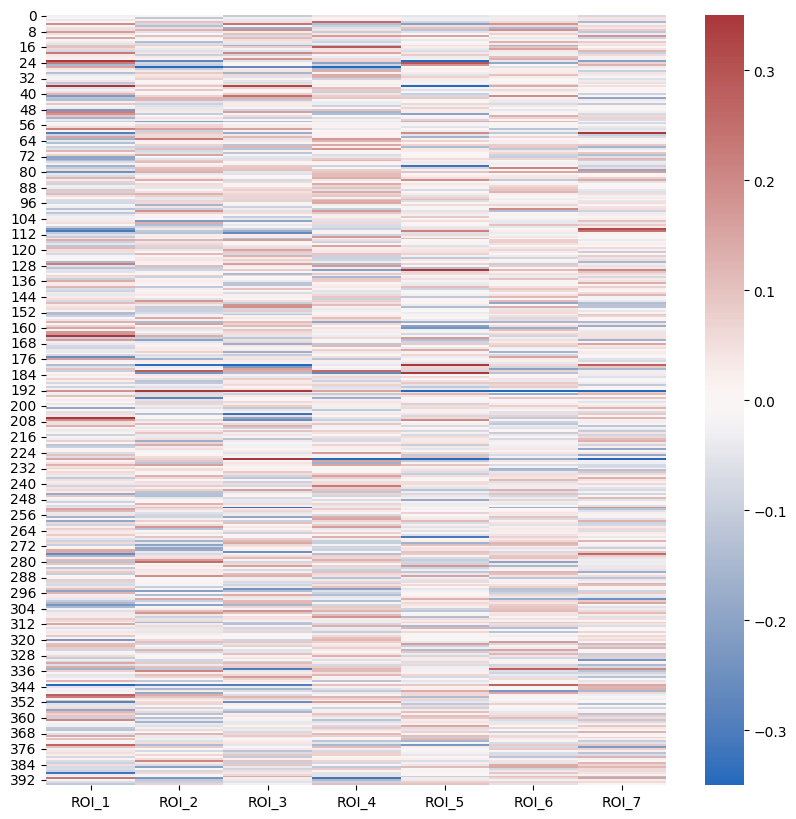

In [12]:
plt.figure(figsize=(10, 10))

sns.heatmap(means_pr_roi.loc[:, means_pr_roi.columns != "subject"],vmax = 0.35,vmin =-0.35,cmap="vlag") # if we ignore huge values

In [13]:
means_pr_roi.loc[:, means_pr_roi.columns != "subject"].corr()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
ROI_1,1.000000,-0.004281,0.273202,-0.178301,-0.262438,-0.184918,-0.257364
ROI_2,-0.004281,1.000000,0.250024,0.521167,-0.195290,-0.202469,-0.197978
ROI_3,0.273202,0.250024,1.000000,-0.034028,-0.490056,0.085564,-0.612350
ROI_4,-0.178301,0.521167,-0.034028,1.000000,-0.025159,0.155738,0.030377
ROI_5,-0.262438,-0.195290,-0.490056,-0.025159,1.000000,0.148449,0.639977
ROI_6,-0.184918,-0.202469,0.085564,0.155738,0.148449,1.000000,0.283252
ROI_7,-0.257364,-0.197978,-0.612350,0.030377,0.639977,0.283252,1.000000


In [14]:
var_pr_roi.loc[:, var_pr_roi.columns != "subject"].corr()

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7
ROI_1,1.000000,0.999059,0.998854,0.999090,0.894711,0.957749,0.984669
ROI_2,0.999059,1.000000,0.999331,0.999582,0.899221,0.961239,0.986892
ROI_3,0.998854,0.999331,1.000000,0.999355,0.904799,0.965385,0.988938
ROI_4,0.999090,0.999582,0.999355,1.000000,0.903254,0.963715,0.988532
ROI_5,0.894711,0.899221,0.904799,0.903254,1.000000,0.980196,0.954871
ROI_6,0.957749,0.961239,0.965385,0.963715,0.980196,1.000000,0.992524
ROI_7,0.984669,0.986892,0.988938,0.988532,0.954871,0.992524,1.000000


<Axes: >

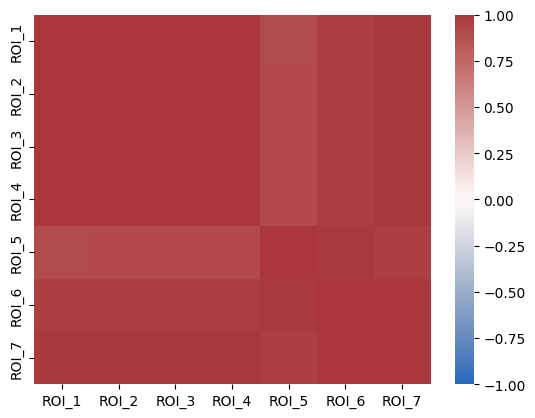

In [15]:
sns.heatmap(var_pr_roi.loc[:, var_pr_roi.columns != "subject"].corr(),cmap = "vlag", vmax=1,vmin=-1)

<Axes: >

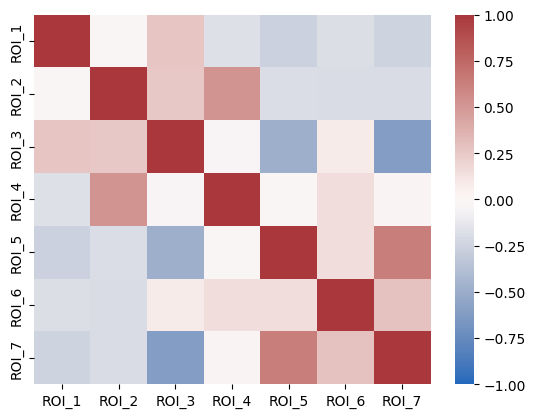

In [16]:
sns.heatmap(means_pr_roi.loc[:, means_pr_roi.columns != "subject"].corr(),cmap = "vlag", vmax=1,vmin=-1)

## TODO
&#x2611; explore variance strangeness

&#x2611; explore means in same way
* Visualizing global patterns over time https://nilearn.github.io/dev/auto_examples/01_plotting/plot_carpet.html
* region activity over time https://nilearn.github.io/dev/auto_examples/06_manipulating_images/plot_nifti_labels_simple.html#sphx-glr-auto-examples-06-manipulating-images-plot-nifti-labels-simple-py


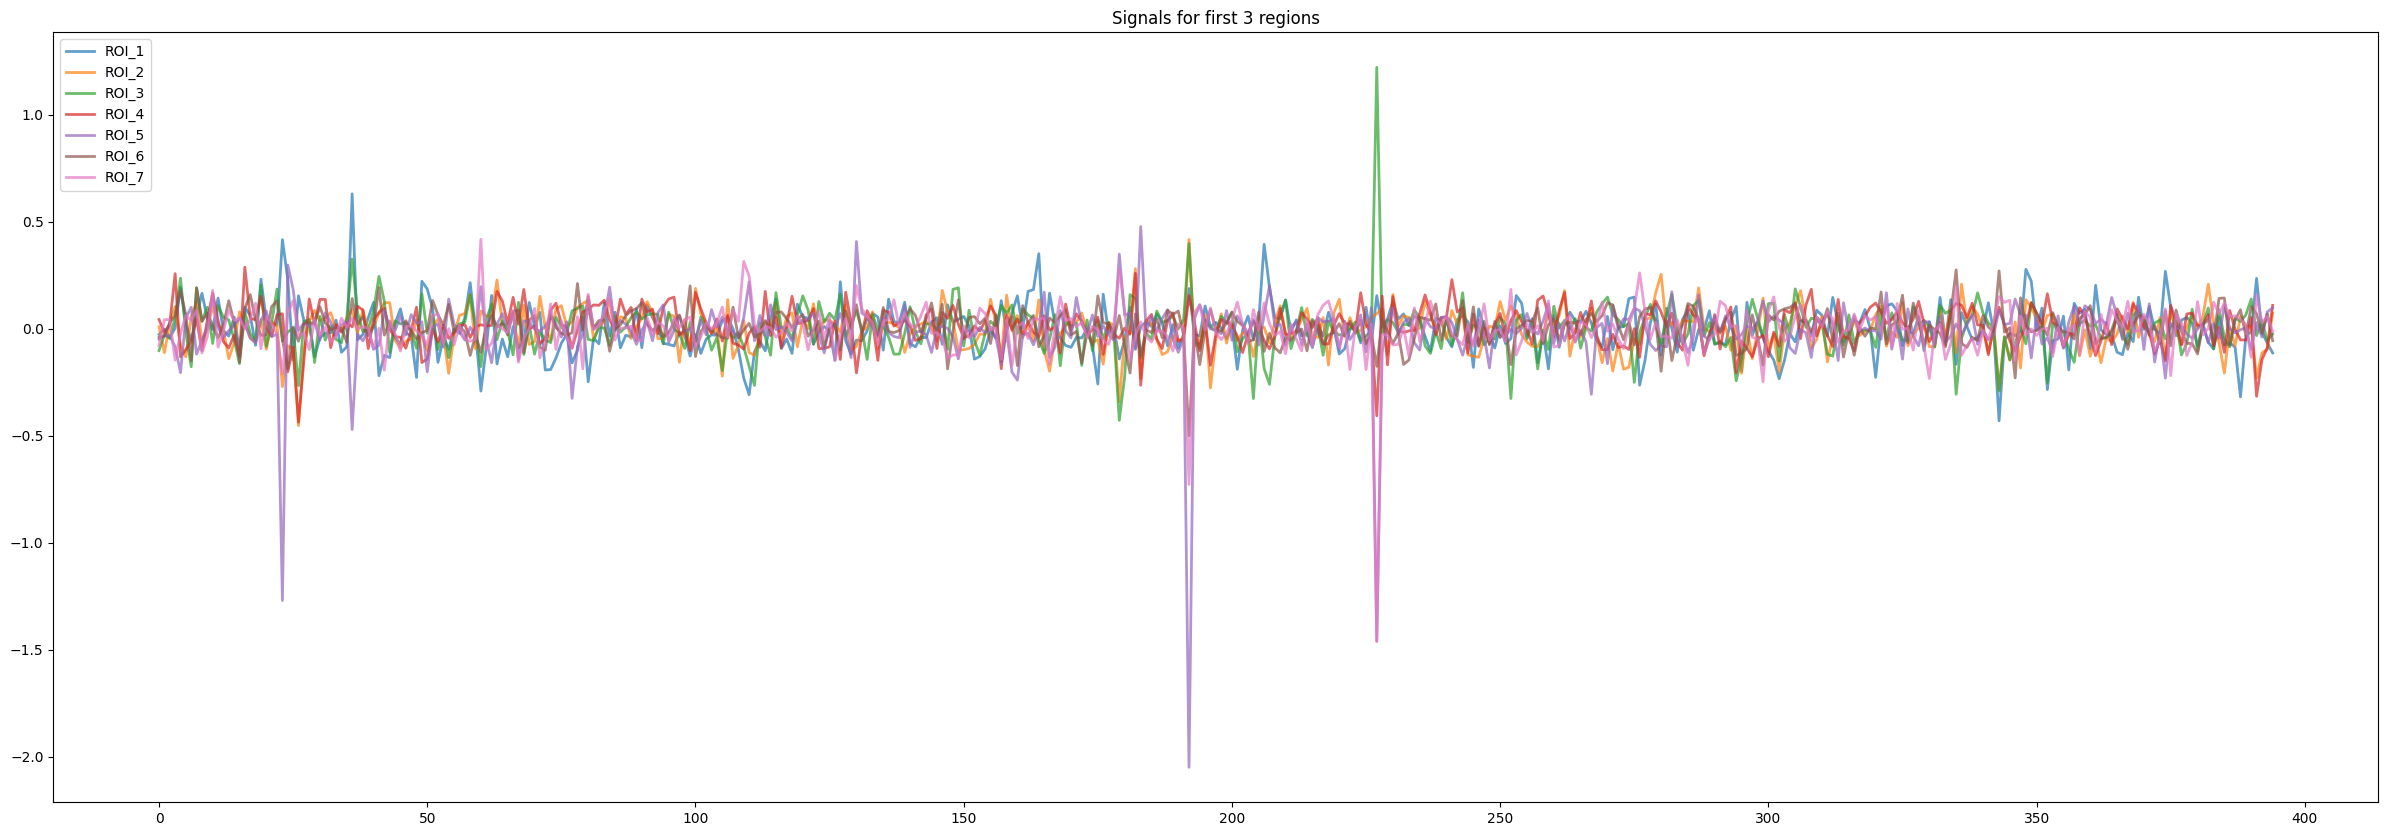

In [ ]:
#WRONG! TODO fix, see below :)
fig = plt.figure(figsize=(30, 10))
ax = fig.add_subplot(111)


for i in means_pr_roi.loc[:, means_pr_roi.columns != "subject"]: #For each ROI 
    ax.plot(
        means_pr_roi[i], linewidth=2, label=i,alpha = 0.7
            ) #would be super cool to align the colour to a diagnosis #TODO exclude huge values

ax.legend(loc=2)
ax.set_title("Signals for first 3 regions")
plt.show()

In [ ]:
# for subject in tqdm(file_list): #For each subject

#     subject = np.load(f'data/clean/NYU/{subject}')
#     for i in subject.files: #For each ROI 
#         if i != "allow_pickle": #TODO fix, there is a strange "Allow pickle thing here sometimes??"
#             roi = subject[i]
#             values = pd.DataFrame()
#             #Get all values from each timestep
#             for t in range(roi.shape[0]):
#                 values[t] = roi[t] #appends
#     break
